# Homework 8 - Deep learning

## Machine Learning Zoomcamp 2025

### Author: Rob Daniels (November 2025)


Requirements:
- PyTorch version 2.8.0

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import ImageFolder
# from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from importlib.metadata import version

print("Numpy version: " + str(np.__version__))
print("Pytorch version: " + str(torch.__version__))
print("Torchsummary: " + str(version("torchsummary")))
print("Torchvision: " + str(version("torchvision")))

Numpy version: 2.3.5
Pytorch version: 2.8.0
Torchsummary: 1.5.1
Torchvision: 0.23.0


### Data

The dataset contains around 1000 images of hairs in the separate folders for training and test sets. The data can be downloaded via terminal from here:

`wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip`

`unzip data.zip`


### Reproducability

Set random seeds

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load and preprocess images

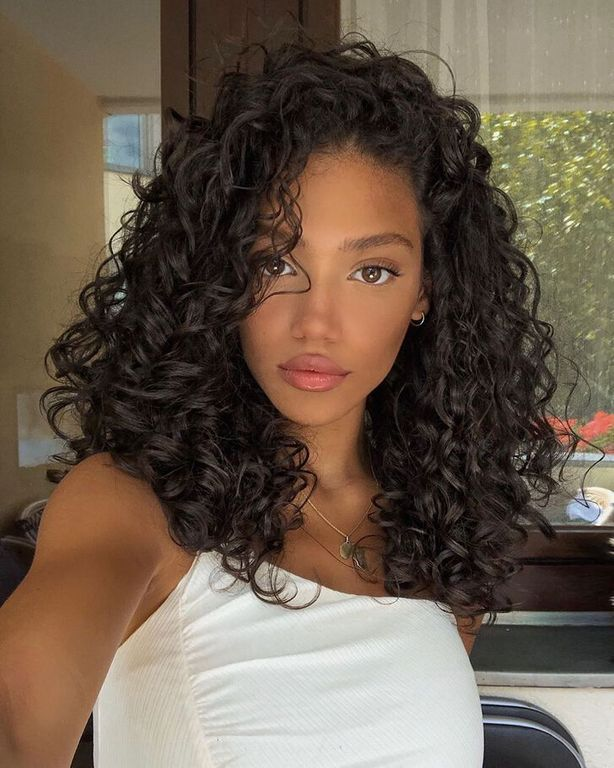

In [3]:
# Load an image
img = Image.open('data/train/curly/00cbad1ffe22d900018e5a2e7376daed4.jpg')

img

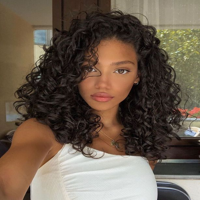

In [4]:
# Resize to target size
img = img.resize((200, 200))

img 

In [5]:
# Convert to numpy array
x = np.array(img)
print(x.shape)  # (200, 200, 3)

(200, 200, 3)


### Build a simple CNN model

- The shape for input should be `(3, 200, 200)` (channels first format in PyTorch)
- Next, create a convolutional layer (`nn.Conv2d`):
  - Use 32 filters (output channels)
  - Kernel size should be `(3, 3)` (that's the size of the filter)
  - Use `'relu'` as activation
- Reduce the size of the feature map with max pooling (`nn.MaxPool2d`)
  - Set the pooling size to `(2, 2)`
- Turn the multi-dimensional result into vectors using `flatten` or `view`
- Next, add a `nn.Linear` layer with 64 neurons and `'relu'` activation
- Finally, create the `nn.Linear` layer with 1 neuron - this will be the output
  - The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `torch.optim.SGD` with the following parameters:
- `torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)`

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convoluational layer: 3 input channels, 32 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3)

        # Max pooling layer: 2x2 pooling size
        self.pool = nn.MaxPool2d(kernel_size = 2)

        # Calculate the flattened size after conv and pooling:
        # Input: (3, 200, 200)
        # After conv with kernel = 3: (32, 198, 198)
        # After pooling with size = 2: (32, 99, 99)
        # Flattened size: 32 * 99 * 99 = 313632

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 99 * 99, 64)

        # Output layer with 1 neuron for binary classification
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Convolutional layer with ReLU
        x = torch.relu(self.conv1(x))

        # Max pooling
        x = self.pool(x)

        # Flatten the feature maps
        x = x.view(x.size(0), -1)  # could also use torch.flatten(x, 1)
        
        # First fully connected layer with ReLU
        x = torch.relu(self.fc1(x))

        # Output layer with sigmoid activation (for binary classification)
        x = torch.sigmoid(self.fc2(x))

        return x

In [7]:
# Create the model
model = CNN()

# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.002, momentum = 0.8)

# Print model summary
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
# Test the model
# Define loss function for binary classification
criterion = nn.BCELoss()  # binary cross-entropy loss

# Reset the seed right before creating the random input
torch.manual_seed(SEED)

# Example input
# batch size = 2, channels = 3, height = 200, width = 200
example_input = torch.randn(2, 3, 200, 200)

# Forward pass
output = model(example_input)
print(output)

tensor([[0.4356],
        [0.4419]], grad_fn=<SigmoidBackward0>)


### Question 1

Which loss function you will use?

The instructions stated that the output layer should have an activation (appropriate for the binary classification case) so I used the `sigmoid()` activation. This means the loss function should techincally be `nn.BCELoss()`. The closest answer conceptually for this loss function is `nn.BCEWithLogitsLoss()` which should really be used without the `sigmoid()` activation.

### Question 2

What's the total number of parameters of the model?

In [9]:
# Option 1: using torchsummary
summary(model, input_size = (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Linear-3                   [-1, 64]      20,072,512
            Linear-4                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.96
Params size (MB): 76.57
Estimated Total Size (MB): 89.00
----------------------------------------------------------------


In [10]:
# Option 2: manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 20073473


### Transform and load the data

In [11]:
input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

train_dataset = ImageFolder("data/train", transform = train_transforms)
test_dataset  = ImageFolder("data/test",  transform = test_transforms)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size = 20,
    shuffle = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 20,
    shuffle = False
)

In [12]:
"""
class HairDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    continue
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
"""

'\nclass HairDataset(Dataset):\n    def __init__(self, data_dir, transform = None):\n        self.data_dir = data_dir\n        self.transform = transform\n        self.image_paths = []\n        self.labels = []\n        self.classes = sorted(os.listdir(data_dir))\n        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}\n\n        for label_name in self.classes:\n            label_dir = os.path.join(data_dir, label_name)\n            for img_name in os.listdir(label_dir):\n                if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):\n                    continue\n                self.image_paths.append(os.path.join(label_dir, img_name))\n                self.labels.append(self.class_to_idx[label_name])\n\n    def __len__(self):\n        return len(self.image_paths)\n\n    def __getitem__(self, idx):\n        img_path = self.image_paths[idx]\n        image = Image.open(img_path).convert(\'RGB\')\n        label = self.labels[idx]\n\n        if self.trans

### Train the model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr = 0.002, momentum = 0.8)
criterion = nn.BCELoss()

### Fit the model

In [14]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'test_acc': [], 'test_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).int()
        total_train += labels.size(0)
        correct_train += (predicted == labels.int()).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    test_running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).int()
            total_test += labels.size(0)
            correct_test += (predicted == labels.int()).sum().item()

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = correct_test / total_test
    history['test_loss'].append(test_epoch_loss)
    history['test_acc'].append(test_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6689, Acc: 0.6125, Test Loss: 0.6023, Test Acc: 0.6517
Epoch 2/10, Loss: 0.5472, Acc: 0.7262, Test Loss: 0.5857, Test Acc: 0.6418
Epoch 3/10, Loss: 0.4944, Acc: 0.7575, Test Loss: 0.5961, Test Acc: 0.6866
Epoch 4/10, Loss: 0.4270, Acc: 0.8025, Test Loss: 0.8213, Test Acc: 0.6418
Epoch 5/10, Loss: 0.3979, Acc: 0.8213, Test Loss: 0.5841, Test Acc: 0.7164
Epoch 6/10, Loss: 0.3484, Acc: 0.8450, Test Loss: 0.7873, Test Acc: 0.6269
Epoch 7/10, Loss: 0.3127, Acc: 0.8638, Test Loss: 0.6967, Test Acc: 0.7114
Epoch 8/10, Loss: 0.2842, Acc: 0.8812, Test Loss: 0.7247, Test Acc: 0.6418
Epoch 9/10, Loss: 0.1862, Acc: 0.9325, Test Loss: 0.6941, Test Acc: 0.7264
Epoch 10/10, Loss: 0.0910, Acc: 0.9788, Test Loss: 0.7473, Test Acc: 0.7264


### Question 3. Median of training accuracy for all the epochs

In [15]:
median_acc = np.median(history['acc'])
print("Median training accuracy:", median_acc)

Median training accuracy: 0.833125


### Question 4. Standard deviation of training loss for all the epochs

In [16]:
std_dev_train_loss = np.std(history['loss'])
print("Standard deviation training loss:", std_dev_train_loss)

Standard deviation training loss: 0.16206286395311253


### Question 5. Mean of test loss for all the epochs

In [17]:
mean_test_loss = np.mean(history['test_loss'])
print("Mean test loss:", mean_test_loss)

Mean test loss: 0.6839524701089408


### Question 6. Average of test accuracy for the last 5 epochs

In [18]:
average_last_5 = np.mean(history['test_acc'][-5:])
print("Average test accuracy for last 5 epochs:", average_last_5)

Average test accuracy for last 5 epochs: 0.6865671641791045
